In [2]:
import os

# Clone ECP repository if not already cloned
if not os.path.exists("ECP"):
    os.system("git clone https://github.com/fouratifares/ECP.git")

In [3]:
cd ECP

/content/ECP


In [4]:
from optimizers.ECP import ECP
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

In [5]:
class Function:
    def __init__(self):
        self.data = self.load_dataset()
        self.X, self.y = self.preprocess_data()
        self.bounds = np.array([(-1, 1), (-1, 1)])  # ln(lambda), ln(sigma)
        self.dimensions = 2  # Two dimensions for ln(lambda) and ln(sigma)

    def load_dataset(self) -> pd.DataFrame:
        """Load the Breast Cancer Wisconsin dataset from the UCI repository."""
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
        column_names = ['ID', 'Diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
        data = pd.read_csv(url, header=None, names=column_names)
        return data

    def preprocess_data(self) -> tuple:
        """Preprocess the data into features and target."""
        # Dropping the ID column
        data = self.data.drop(columns=['ID'])

        # Convert the 'Diagnosis' column to binary (M: 1, B: 0)
        data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

        # Extract features (X) and target (y)
        X = data.iloc[:, 1:].values  # Features (all columns except 'Diagnosis')
        y = data.iloc[:, 0].values  # Target ('Diagnosis')
        return X, y

    def __call__(self, x: np.ndarray = None, **kwargs) -> float:
        """Evaluate the model by performing kernel ridge regression."""

        if x is not None:
            # Handle input as a numpy array
            if len(x) != self.dimensions:
                raise ValueError(f"Input must have {self.dimensions} dimensions.")

        x = np.array(x)  # Ensure x is a numpy array
        lambda_vals = [np.exp(x[0])]
        sigma_vals = [np.exp(x[1])]

        all_rewards = []
        for lambda_, sigma_ in zip(lambda_vals, sigma_vals):
            kf = KFold(n_splits=3)
            mse_scores = []

            for train_index, test_index in kf.split(self.X):
                X_train, X_test = self.X[train_index], self.X[test_index]
                y_train, y_test = self.y[train_index], self.y[test_index]

                # Standardizing features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

                # Model fitting
                model = KernelRidge(alpha=lambda_, kernel='rbf', gamma=1 / (2 * sigma_ ** 2))
                model.fit(X_train, y_train)

                # Predictions and MSE calculation
                y_pred = model.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                mse_scores.append(mse)  # Collecting individual MSE for each fold

            # Collecting the mean reward for each (lambda_, sigma_)
            mean_reward = -np.mean(mse_scores)

        return np.array(mean_reward)

The Global Search is Completed
Best Point: [-0.93802097  0.99626649]
Maximum Value: -0.0710791834825265




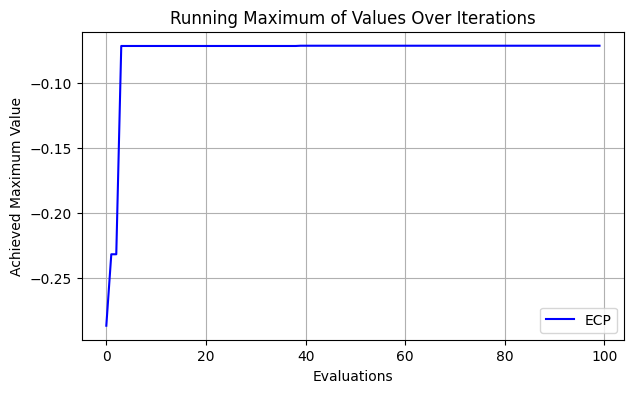

In [6]:
f = Function()
points, values, epsilons = ECP(f, n = 100)

# Retrieve the corresponding point
best_point = points[np.argmax(values)]

print("The Global Search is Completed")
print("Best Point:", best_point)
print("Maximum Value:", max(values))
print("\n")

# Compute running maximum
running_max = np.maximum.accumulate(values)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(running_max, label="ECP", color="blue")
plt.xlabel("Evaluations")
plt.ylabel("Achieved Maximum Value")
plt.title("Running Maximum of Values Over Iterations")
plt.legend()
plt.grid()
plt.show()